In [17]:
from scipy.spatial import distance
import pandas as pd
import numpy as np
import os
from pyspark.sql import SparkSession,Row
import pyspark.sql.functions as F
import geopandas as gpd
import matplotlib.pyplot as plt
from math import pi


In [18]:
#Start a session
spark = SparkSession.builder.master('local').getOrCreate()

#Read in the data
df = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/DataSample.csv'))

# 1.Cleanup

In [19]:
#Total number of records
df.count()

22025

In [20]:
#The column names
df.columns

['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']

In [21]:
#A new dataframe with just the duplicates
duplicate_df = df.exceptAll(df.drop_duplicates([df.columns[1],df.columns[-2],df.columns[-1]]))

In [22]:
#Dataframe with all the suspicious(same time,latitude and longitude) records removed
df_clean = df.drop_duplicates([df.columns[1],df.columns[-2],df.columns[-1]])\
.join(duplicate_df,on=[df.columns[1],df.columns[-2],df.columns[-1]],how='left_anti').persist()

In [23]:
#Number of clean records
df_clean.count()

17973

# 2.Label


In [24]:
#Reading in the points of interests. I am ignoring POI2 as it is the same as POI1
poi = pd.read_csv("data/POIList.csv").values[1:,1:3]
poi

array([[53.546167, -113.485734],
       [45.521629, -73.566024],
       [45.22483, -63.232729]], dtype=object)

In [25]:
def get_dist(row,poi):
    '''
    Calulate the distance between a row of the dataframe and the different points of interets. 
    Returns a (key,value) where key is the closest POI(numbered from 0 to 2)
    and value is of the form (row_ID,row_latitude,row_longitude,closest_POI_latitude,closest_POI_longitude,distance)
    '''
    minimum = np.inf
    for i in range(len(poi)):
        dist = distance.euclidean([row[1],row[2]],poi[i])
        if dist < minimum:
            minimum = dist
            closest = i
    return (closest,(row[3],row[1],row[2],poi[closest][0],poi[closest][1],minimum))
        

In [26]:
#Map the cleaned data with the get_dist function
poi_data = df_clean.rdd.map(lambda x:get_dist(x,poi))

In [27]:
#Create a dataframe of POI and distance to calculate the mean and sd
average_sd = poi_data.map(lambda x:Row(int(x[0]),int(x[1][0]),float(x[1][-1])))\
.toDF(["POI","ID","distance"])

In [28]:
#Each ID is mapped to one POI
average_sd.show()

+---+-------+-------------------+
|POI|     ID|           distance|
+---+-------+-------------------+
|  1|5613403| 6.3007899643470875|
|  1|5013924|  6.184145220595726|
|  0|5122425| 2.4708235749735343|
|  0|4571908|  2.516245170297398|
|  1|5447065|  6.109398439689215|
|  0|4843104| 0.1473602274869269|
|  1|5337456| 2.6034157457496074|
|  0|5413296| 4.1593103029522815|
|  0|4693076|  2.693106240133315|
|  0|5329292|  2.543702304564155|
|  0|5431366|  2.537096019926126|
|  0|5500911| 2.7123473003221736|
|  1|5060850|  6.150588105947017|
|  1|5154104|  6.103947182341687|
|  1|5203240|  6.071944169771085|
|  0|4623647|0.11977913526570445|
|  0|5444477|  6.987450394059693|
|  0|4834753|0.05290869725289831|
|  0|5103797|  3.818857224749962|
|  0|5176665|  2.472535411181199|
+---+-------+-------------------+
only showing top 20 rows



# 3.Analysis

In [29]:
average_sd = average_sd.groupBy("POI")

- 0 refers to POI1
- 1 refers to POI3
- 2 refers to POI4

In [30]:
#Mean
average_sd.mean("distance").show()

+---+------------------+
|POI|     avg(distance)|
+---+------------------+
|  0|3.3531117689402135|
|  1| 5.537919139655464|
|  2| 8.522389808711123|
+---+------------------+



In [31]:
#Standard deviation
average_sd.agg(F.stddev("distance")).show()

+---+---------------------+
|POI|stddev_samp(distance)|
+---+---------------------+
|  0|   3.8496400815971294|
|  1|   2.8587108750939807|
|  2|   27.334583163851153|
+---+---------------------+



In [32]:
#The radius of the circle or the maximum distance from the POI
radius = average_sd.max("distance").collect()
radius

[Row(POI=0, max(distance)=24.851937229893878),
 Row(POI=1, max(distance)=20.155377791591437),
 Row(POI=2, max(distance)=192.7049913074258)]

In [33]:
#Number of requests in each POI
count = average_sd.count().collect()
count

[Row(POI=0, count=8725), Row(POI=1, count=8821), Row(POI=2, count=427)]

In [34]:
#Request density
for i in range(len(radius)):
    density = count[i][1]/(pi*radius[i][1]*radius[i][1])
    print("Density (Request/Area) of POI",i,"is",density)

Density (Request/Area) of POI 0 is 4.496711933878291
Density (Request/Area) of POI 1 is 6.911718842827215
Density (Request/Area) of POI 2 is 0.00366009261696348


In [44]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [45]:
gpd_df = pd.DataFrame(
    {
     'Latitude': poi[:,0],
     'Longitude': poi[:,1]})

gdf = gpd.GeoDataFrame(
gpd_df, geometry=gpd.points_from_xy(gpd_df.Longitude,gpd_df.Latitude))

In [46]:
circle0 = plt.Circle(poi[0][::-1], radius[0][1], color='r',fill=False)
circle1 = plt.Circle(poi[1][::-1], radius[1][1], color='b',fill=False)
circle2 = plt.Circle(poi[2][::-1], radius[2][1], color='g',fill=False)

<AxesSubplot:>

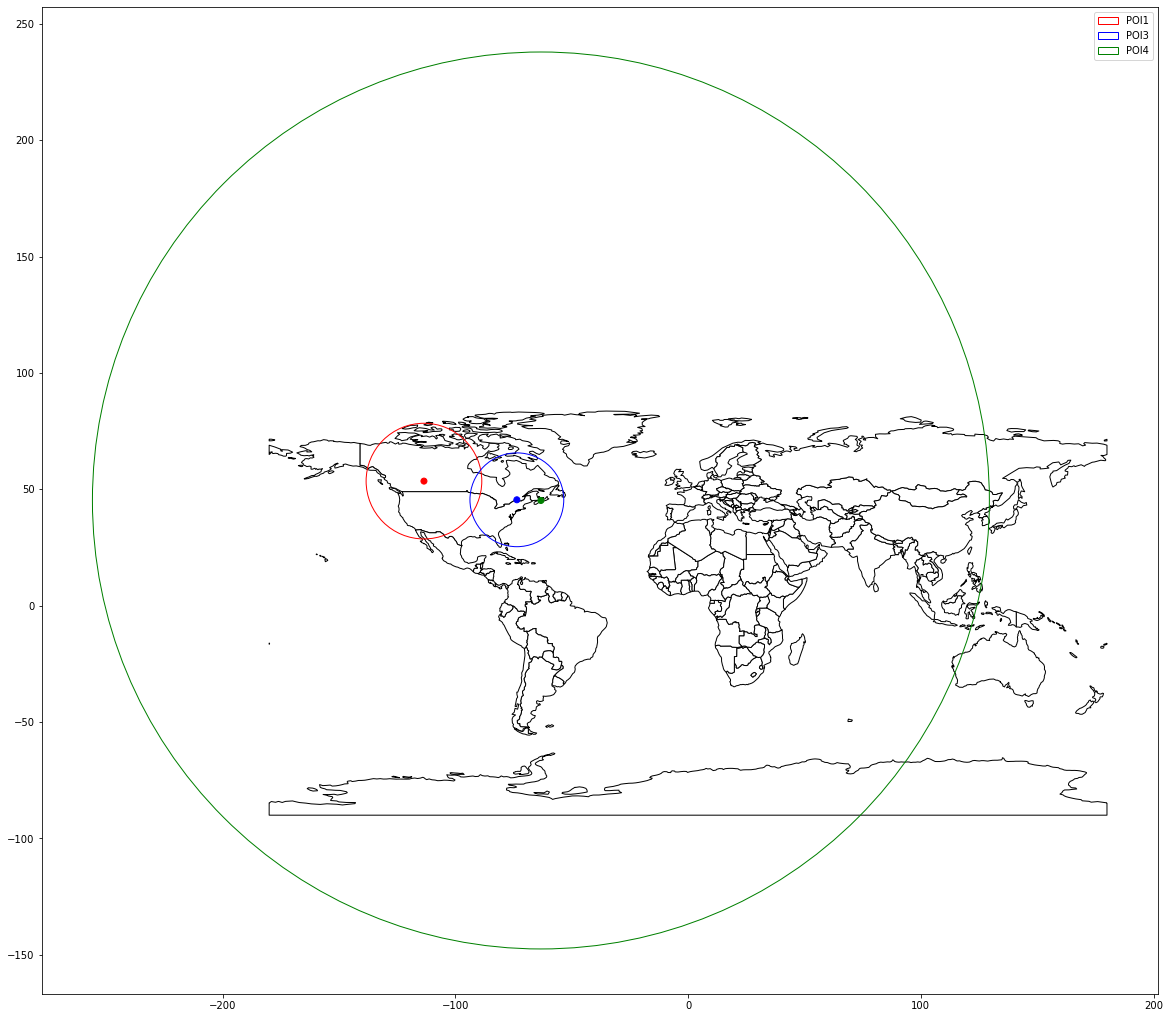

In [47]:
ax = world.plot(
    color='white', edgecolor='black',figsize=(20,20))
ax.add_patch(circle0)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.legend(["POI1","POI3","POI4"])
gdf.plot(ax=ax,facecolor=['r','b','g'])



# 4b. Pipeline Dependency

In [66]:
#Library for topological sort 
from toposort import toposort

In [67]:
#Read in the questions

with open("question.txt","r") as f:
    question = f.readlines()

with open("relations.txt","r") as f:
    relations = f.readlines()

with open("task_ids.txt","r") as f:
    task_ids = f.readlines()

In [68]:
#Start and Goal state
start = [int(s) for s in question[0].split() if s.isdigit()][0]
goal = [int(s) for s in question[1].split() if s.isdigit()][0]

In [70]:
print("Start:",start)
print("Goal:",goal)

Start: 73
Goal: 36


In [71]:
#Create dependency dictionary
dep = dict()
for i in relations:
    i = i.rstrip().split('->')
    i[0] = int(i[0])
    i[1] = int(i[1])
    if i[1] not in dep:
        dep[i[1]] = set([i[0]])
    else:
        dep[i[1]].add(i[0])

In [72]:
#Dependencies
dep

{102: {56, 94, 97},
 31: {55, 75, 102},
 37: {16, 55, 75, 102},
 20: {21, 73, 100},
 36: {102},
 73: {39, 41},
 100: {39},
 112: {41},
 55: {56, 62},
 97: {20, 112},
 94: {20},
 75: {56},
 56: {94}}

In [55]:
#Get the topological sorted order
order = list(toposort(dep))
order

[{16, 21, 39, 41, 62},
 {73, 100, 112},
 {20},
 {94, 97},
 {56},
 {55, 75, 102},
 {31, 36, 37}]

In [78]:
def get_previous_tasks(task,dep):
    '''
    This function takes in a task, dependency dictonary. It returns all the ancestors of the given task
    in a set data structure.
    '''
    anc_task = set()
    if task in dep:
        anc_task = anc_task.union(dep[task])
        for i in dep[task]:
            anc_task = anc_task.union(get_previous_tasks(i,dep))
    return anc_task
        
    

In [87]:
#Get all completed task based on the start task
comp_tasks = get_previous_tasks(start,dep)
comp_tasks

{39, 41}

In [82]:
#Get all the tasks necessary for the goal task
necessary_tasks = get_previous_tasks(goal,dep)
necessary_tasks

In [88]:
#The necesassry tasks to run which is the set difference between completed and necessary tasks
step = necessary_tasks - comp_tasks
step

{20, 21, 56, 73, 94, 97, 100, 102, 112}

In [93]:
#The final answer sorted topologically
to_print = []
for i in order:
    tasks = i.intersection(step)
    if len(tasks)>0:
        for j in tasks:
            to_print.append(j)
to_print.append(goal)
print(to_print)

[21, 112, 73, 100, 20, 97, 94, 56, 102, 36]
